In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
import time
import os
import sys
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
sys.path.insert(0, '/work/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import photxspec
import corrfuncs
import linear_theory
import tools

### load TNG snapshots

In [3]:
# main inputs
snapshots = np.arange(41, 60).astype(int) # np.arange(63, 73) to center at z=0.5
sigma_z = 0.1  # one of the 5 redshift error bins in SPHEREx

In [4]:
# there is a jump in SPHEREx galaxy number density around z=1; we want to interpolate this

# first get the target number densities
redshifts = np.empty(len(snapshots))
target_ns = np.empty(len(snapshots))
for i, snapshot in enumerate(snapshots):
    sim = TNGSim('TNG300-3', snapshot=snapshot)
    redshifts[i] = sim.redshift
    target_ns[i] = sim.survey_params('SPHEREx', '', sigma_z).n_Mpc3 # * (u.littleh / u.Mpc)**3
target_ns *= (u.littleh / u.Mpc)**3 # return units

# now interpolate
target_ns_interp = tools.interpolate_number_densities(redshifts, target_ns)

In [5]:
# ACTUALLY let's keep number density constant
target_n = np.mean(target_ns_interp)

Text(0.5, 1.0, 'Target galaxy number densities with $\\sigma_z=$0.1: interpolation')

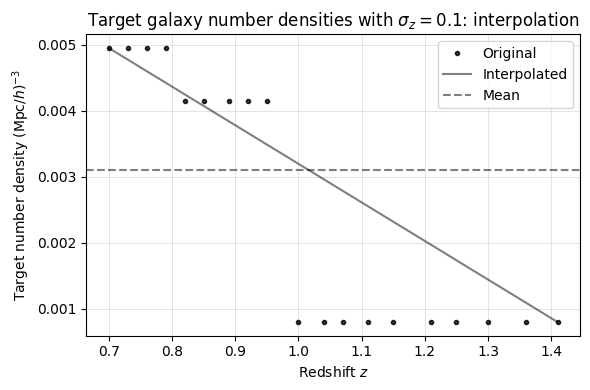

In [6]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(redshifts, target_ns, 'k.', alpha=0.8, label='Original')
ax.plot(redshifts, target_ns_interp, 'k-', alpha=0.5, label='Interpolated')
ax.axhline(target_n, c='k', ls='--', alpha=0.5, label='Mean')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Target number density (Mpc/$h)^{-3}$')
ax.legend()
ax.set_title(r'Target galaxy number densities with $\sigma_z=$'f'{sigma_z}: interpolation')

In [9]:
data = photxspec.construct_spherex_galaxy_samples(snapshots, sigma_z, ns=target_n * np.ones_like(redshifts))
redshifts, chis, gal_pos_specs, boxsize = data['redshifts'], data['chis'], data['gal_pos_specs'], data['boxsize']

input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
removing 1 values
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
removing 1 values
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
input number density: 3.10e-03 (h/Mpc)^3
target number of subhalos: 26701
in

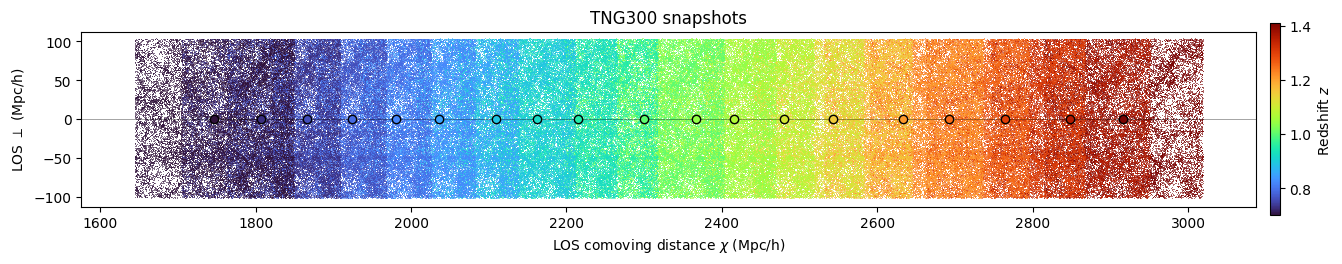

In [10]:
# plot
norm = mpl.colors.Normalize(vmin=min(redshifts), vmax=max(redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(15,2.6), tight_layout=True)
for i, chi in enumerate(chis):
    gal_pos_spec_ = np.copy(gal_pos_specs[i])
    gal_pos_spec_[:,2] += chi
    kwargs = dict(c=smap.to_rgba(redshifts[i]), ls='None')
    ax.plot(gal_pos_spec_[:,2], gal_pos_spec_[:,0], marker=',', alpha=0.6, **kwargs)
    ax.plot(chi, 0, marker='o', c=smap.to_rgba(redshifts[i]), mec='k', zorder=100)
    ax.axvline((chi - boxsize/2).value, alpha=0.8, **kwargs)
    ax.axvline((chi + boxsize/2).value, alpha=0.8, **kwargs)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.set_aspect('equal')
ax.set_xlabel(r'LOS comoving distance $\chi$ (Mpc/h)')
ax.set_ylabel(r'LOS $\perp$ (Mpc/h)')
ax.set_title(r'TNG300 snapshots')
fig.colorbar(smap, ax=ax, label='Redshift $z$', pad=0.01)

### photometric weights

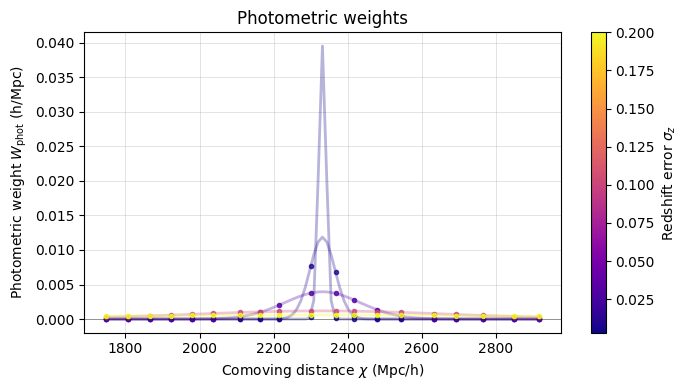

In [11]:
# plot for all sigma_zs
sigma_zs = [0.003, 0.01, 0.03, 0.1, 0.2]

fig, ax = plt.subplots(figsize=(7,4), tight_layout=True)
norm = mpl.colors.Normalize(vmin=min(sigma_zs), vmax=max(sigma_zs))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='plasma')

for i, sigma_z_ in enumerate(sigma_zs):
    dx = tools.get_dx(np.nanmean(redshifts), sigma_z_)
    
    # on a finer grid
    chis_fine = np.linspace(min(chis.value), max(chis.value), 101)
    W_phot_fine = [
        tools.eval_Gaussian(chi, dx.value, mean=np.nanmean(chis_fine)) for chi in chis_fine
    ]

    # and at the snapshot centers
    W_phot = [
        tools.eval_Gaussian(chi.value, dx.value, mean=np.nanmean(chis_fine)) for chi in chis
    ]
    
    ax.plot(chis_fine, W_phot_fine, ls='-', lw=2, alpha=0.3, c=smap.to_rgba(sigma_z_))
    label = 'Snapshot centers' if i == 0 else ''
    ax.plot(chis.value, W_phot, marker='.', alpha=0.8, ls='None', label=label, c=smap.to_rgba(sigma_z_))
    
ax.axhline(0, alpha=0.5, c='k', lw=0.5)
ax.grid(alpha=0.5, lw=0.5)
# ax.semilogy()
ax.set_xlabel(r'Comoving distance $\chi$ (Mpc/h)')
ax.set_ylabel(r'Photometric weight $W_\mathrm{phot}$ (h/Mpc)')
ax.set_title('Photometric weights')
fig.colorbar(smap, ax=ax, label=r'Redshift error $\sigma_z$')

### compute projected auto-correlation in each snapshot

In [12]:
# INPUTS #
randmult = 3
rpmin = 0.1
rpmax = 60
nrpbins = 10
pimax = int(0.45 * boxsize.value) # max depth to integrate along LOS
nthreads = 10
periodic = True
nrepeats = 10  # how many times to repeat computation to help with noise / numerical errors ?

In [13]:
# compute and store wp(rp) from each reference galaxy sample
wps = np.full((len(snapshots),nrpbins), np.nan)
for i, gal_pos_spec in enumerate(gal_pos_specs):
    print(f"{i+1} / {len(snapshots)}", end='\r')
    rp_avg, wps[i] = corrfuncs.compute_wp_auto(gal_pos_spec, randmult, rpmin, rpmax, nrpbins, pimax,
                    boxsize=boxsize, logbins=True, nrepeats=nrepeats, nthreads=nthreads, periodic=periodic)

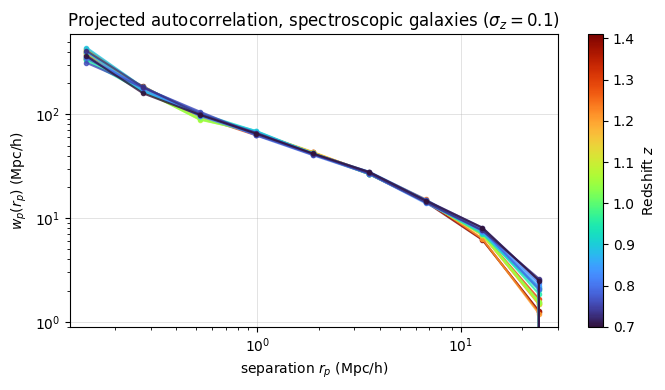

In [14]:
# plot
norm = mpl.colors.Normalize(vmin=min(redshifts), vmax=max(redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(7,4), tight_layout=True)

for i, wp in enumerate(wps):
    ax.plot(rp_avg, wp, c=smap.to_rgba(redshifts[i]), alpha=0.8, marker='.')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlim(1.2e-1, 3e1)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$ (Mpc/h)')
ax.set_title(f"Projected autocorrelation, spectroscopic galaxies "r"($\sigma_z=$"f"{sigma_z})")
fig.colorbar(smap, ax=ax, label=r'Redshift $z$')

#### assume isotropy: compute from $\xi(r)$ ; compare to linear theory

In [15]:
# inputs: separation bins
rmin = 0.1
rmax = 100
nbins = 10

In [16]:
# compute the pair counts
xis = np.full((len(snapshots),nbins), np.nan)
for i, gal_pos_spec in enumerate(gal_pos_specs):
    r_avg, xis[i] = corrfuncs.compute_xi_auto(gal_pos_spec, rmin, rmax, nbins, randmult=randmult,
                                             boxsize=boxsize, nrepeats=nrepeats,
                                             nthreads=nthreads, periodic=periodic)

In [17]:
# load biases calculated for each snapshot ('auto_gal' method)
bias_res = np.load(os.path.join('/scratch1/08811/aew492/TNG300-3/bias',
                f'bias_z-{min(redshifts):.2f}-{max(redshifts):.2f}_sigmaz-{sigma_z}_n_fixed.npy'),
                 allow_pickle=True).item()
assert np.allclose(bias_res['ns'], target_n * np.ones_like(redshifts))
biases = bias_res['biases']

Text(0.5, 1.0, 'Galaxy bias: $b(r) = \\sqrt{\\xi_\\mathrm{Gal\\,x\\,Gal}(r)\\,/\\,\\xi_\\mathrm{lin}(r)}$')

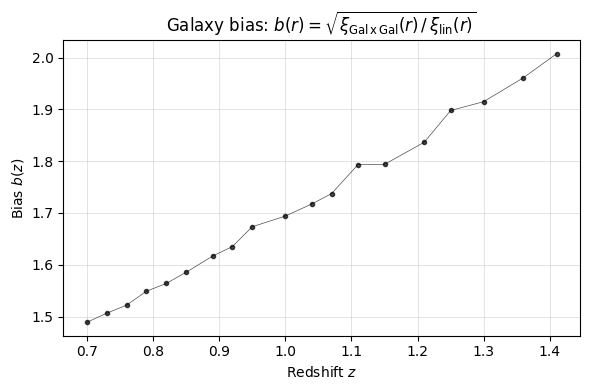

In [18]:
# plot
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(redshifts, biases, 'k.-', alpha=0.7, lw=0.5)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Bias $b(z)$')
ax.set_title(f'Galaxy bias: 'r'$b(r) = \sqrt{\xi_\mathrm{Gal\,x\,Gal}(r)\,/\,\xi_\mathrm{lin}(r)}$')

In [19]:
# galaxy c.f. is the matter c.f. times the bias squared
xi_lins = np.array([
    np.mean(biases) * tools.linear_2pcf(redshift, r_avg) for i, redshift in enumerate(redshifts)
])

In [20]:
# use these xi(r) as a lookup table to interpolate (rp,pi)
rp = rp_avg
pi = rp_avg # also use rp_avg for pi
# populate 2D array of separation r from each (r_p, pi) pair
r_arr = tools.r_from_rppi(rp, pi) 

# linear wp(rp) from linear xi(r)
wps_lin_isotropic = np.full_like(wps, np.nan)
for i, xi_lin in enumerate(xi_lins):
    # interpolate xi(r) on this r_arr grid
    xi_lin_arr = np.exp(np.interp(np.log(r_arr), np.log(r_avg), np.log(xi_lin)))
    # sum over pi / r_parallel to get 1D wp(rp)
    wps_lin_isotropic[i] = 2.0 * integrate.trapz(xi_lin_arr, x=pi, axis=0)

# wp(rp) from xi(r)
wps_isotropic = np.full_like(wps, np.nan)
for i, xi in enumerate(xis):
    xi_arr = np.exp(np.interp(np.log(r_arr), np.log(r_avg), np.log(xi)))
    # !! manually inserting -1 index to avoid NaNs (where xi went negative)
    wp_ = 2.0 * integrate.trapz(xi_arr[:-1,:-1], x=pi[:-1], axis=0)
    wps_isotropic[i] = np.append(wp_, np.nan)

/work/08811/aew492/frontera/venv/illustris/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


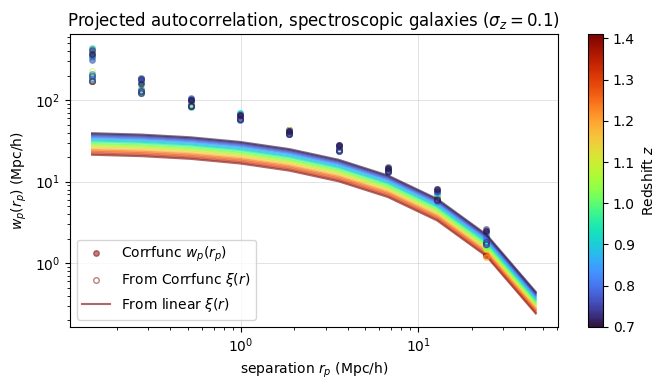

In [21]:
fig, ax = plt.subplots(figsize=(7,4), tight_layout=True)

for i in range(len(snapshots)):
    kwargs = dict(marker='o', ls='None', alpha=0.5, ms=4)
    label = r'Corrfunc $w_p(r_p)$' if i==0 else ''
    ax.plot(rp, wps[i], label=label, c=smap.to_rgba(redshifts[i]), **kwargs)
    label = r'From Corrfunc $\xi(r)$' if i==0 else ''
    ax.plot(rp, wps_isotropic[i], label=label, mec=smap.to_rgba(redshifts[i]), c='None', **kwargs)
    label = r'From linear $\xi(r)$' if i==0 else ''
    ax.plot(rp, wps_lin_isotropic[i], alpha=0.6, label=label, c=smap.to_rgba(redshifts[i]))
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$ (Mpc/h)')
ax.set_title(f"Projected autocorrelation, spectroscopic galaxies ("r"$\sigma_z=$"f"{sigma_z})")
ax.legend(loc=3)
fig.colorbar(smap, ax=ax, label=r'Redshift $z$')

### photometric weights

In [22]:
# redshift error in comoving coordinates
dx = tools.get_dx(np.nanmean(redshifts), sigma_z)
dx

<Quantity 336.62203612 Mpc / littleh>

In [23]:
# on a finer grid
chis_fine = np.linspace(min(chis.value), max(chis.value), 101)
W_phot_fine = [
    tools.eval_Gaussian(chi, dx.value, mean=np.nanmean(chis_fine)) for chi in chis_fine
]

# and at the snapshot centers
W_phot = [
    tools.eval_Gaussian(chi.value, dx.value, mean=np.nanmean(chis_fine)) for chi in chis
]

Text(0.5, 1.0, 'Photometric weights for $\\sigma_z=$0.1')

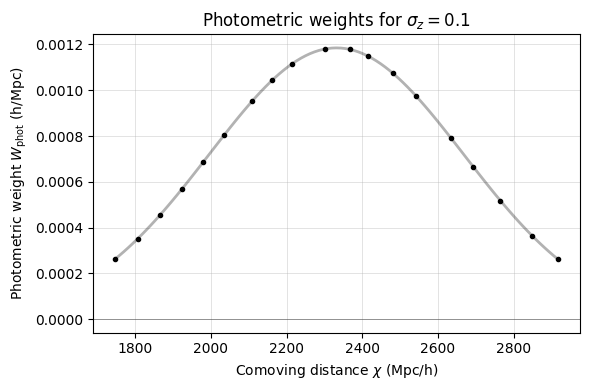

In [24]:
# plot
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(chis_fine, W_phot_fine, 'k-', lw=2, alpha=0.3)
ax.plot(chis.value, W_phot, 'k.', label='Snapshot centers')
ax.axhline(0, alpha=0.5, c='k', lw=0.5)
ax.grid(alpha=0.5, lw=0.5)
# ax.semilogy()
ax.set_xlabel(r'Comoving distance $\chi$ (Mpc/h)')
ax.set_ylabel(r'Photometric weight $W_\mathrm{phot}$ (h/Mpc)')
ax.set_title(r'Photometric weights for $\sigma_z=$'f'{sigma_z}')

### angular cross-correlation

In [25]:
# multiply each projected auto-correlation function by the corresponding photometric weight
#  this effectively gives us the angular cross-correlation function
wthetax = np.array([
    W_phot[i] * wps[i] for i in range(len(snapshots))
])
wthetax_lin = np.array([
    W_phot[i] * wps_lin_isotropic[i] for i in range(len(snapshots))
])

In [26]:
# ! note redshift needs to be defined in the TNGSim earlier;
#    to use with mpl axis labels, we need a single input and dimensionless output
def theta_to_r_comov_(theta):  # theta in DEGREES
    return tools.theta_to_r_comov(theta, sim.redshift).value
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, sim.redshift).value

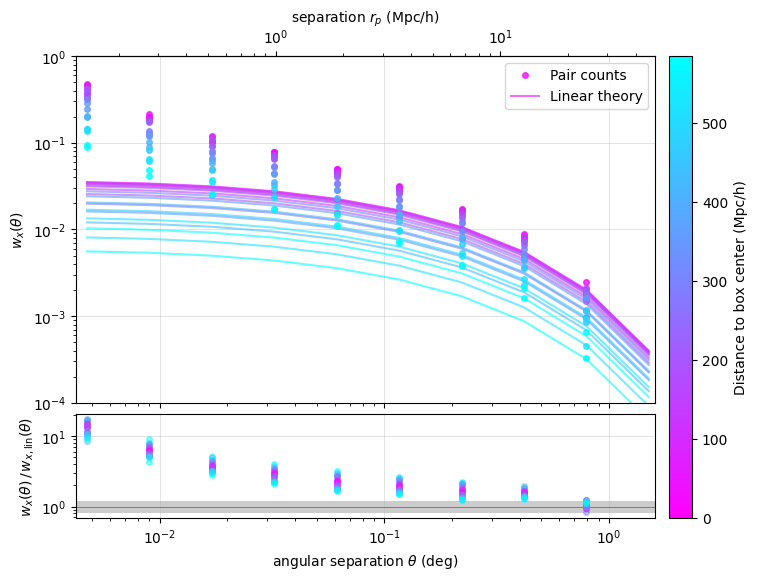

In [27]:
# now color by distance to box center
norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(np.abs(chis.value-np.nanmean(chis_fine))))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig = plt.figure(figsize=(9,6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.3], hspace=0.05)
    
ax0 = fig.add_subplot(gs[0])
thetaavg = r_comov_to_theta_(rp_avg)
for i, w in enumerate(wthetax):
    kwargs = dict(c=smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine))))
    label = 'Pair counts' if i==len(wthetax)//2 else ''
    ax0.plot(thetaavg, w, marker='o', ms=4, ls='None', alpha=0.8, label=label, **kwargs)
    label = 'Linear theory' if i==len(wthetax)//2 else ''
    ax0.plot(thetaavg, wthetax_lin[i], alpha=0.6, label=label, **kwargs)
secax = ax0.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax0.set_ylim(1e-4,1e0)
ax0.set_ylabel(r'$w_x(\theta)$')
ax0.legend()

ax1 = fig.add_subplot(gs[1])
ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
for i, w in enumerate(wthetax):
    ax1.plot(thetaavg, w / wthetax_lin[i], marker='o', ms=4, alpha=0.5, ls='None',
             c=smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine))))
ax1.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
ax1.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')
ax1.set_xlabel(r'angular separation $\theta$ (deg)')

for ax in (ax0, ax1):
    ax.loglog()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlim(min(thetaavg)-5e-4, max(thetaavg)+1e-1)

fig.colorbar(smap, ax=[ax0,ax1], label='Distance to box center (Mpc/h)', pad=0.02)
# fig.suptitle('Phot. x spec. cross-correlation ($\sigma_z=$'f'{sigma_z}; d'r'$x=$'f'{dx.value:.0f} Mpc/h)',
#              x=0.45, y=1.)

In [33]:
# save the data we need for the plot!
res = dict(sigma_z=sigma_z, dx=dx, chis=chis, chis_fine=chis_fine,
           rp_avg=rp_avg, thetaavg=thetaavg, wthetax=wthetax, wthetax_lin=wthetax_lin,
          redshifts=redshifts, bias=biases, ns=target_n * np.ones_like(redshifts))
np.save(f'wthetax_res_z{min(redshifts)}-{max(redshifts)}_sigmaz{sigma_z}_n-fixed.npy', res)

### load results and plot

In [23]:
# redshift errors
sigma_zs = [0.1, 0.2]

In [24]:
def plot_wthetax(sigma_z, min_redshift, max_redshift, figsize=(9,6), xlim=(5e-3, 1.5e0), ylim=(2e-4,1e0),
                 legend_loc=0, cmap='cool_r', title=True):
    # load dict
    res = np.load(f'wthetax_res_z{min_redshift}-{max_redshift}_sigmaz{sigma_z}.npy', allow_pickle=True).item()
    # unpack
    dx = res['dx']
    chis, chis_fine = res['chis'], res['chis_fine']
    rp_avg, thetaavg = res['rp_avg'], res['thetaavg']
    wthetax, wthetax_lin = res['wthetax'], res['wthetax_lin']
    
    fig = plt.figure(figsize=figsize)
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.4], hspace=0.05)
    # color by distance to box center
    norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(np.abs(chis.value-np.nanmean(chis_fine))))
    smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    ax0 = fig.add_subplot(gs[0])
    for i, w in enumerate(wthetax):
        kwargs = dict(c=smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine))))
        label = 'Pair counts' if i==len(wthetax)//2 else ''
        ax0.plot(thetaavg, w, marker='o', ms=4, ls='None', alpha=0.8, label=label, **kwargs)
        label = 'Linear theory' if i==len(wthetax)//2 else ''
        ax0.plot(thetaavg, wthetax_lin[i], alpha=0.6, label=label, **kwargs)
    secax = ax0.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
    secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
    ax0.set_ylim(ylim)
    ax0.set_ylabel(r'$w_x(\theta)$')
    ax0.legend(loc=legend_loc)

    ax1 = fig.add_subplot(gs[1])
    ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
    for i, w in enumerate(wthetax):
        ax1.plot(thetaavg, w / wthetax_lin[i], marker='o', ms=4, alpha=0.5, ls='None',
                 c=smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine))))
    ax1.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
    ax1.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')
    ax1.set_xlabel(r'angular separation $\theta$ (deg)')

    for ax in (ax0, ax1):
        ax.loglog()
        ax.grid(alpha=0.5, lw=0.5)
        ax.set_xlim(xlim)

    fig.colorbar(smap, ax=[ax0,ax1], label='Distance to box center (Mpc/h)', pad=0.02)
    if title:
        fig.suptitle('Phot. x spec. cross-correlation ($\sigma_z=$'f'{sigma_z}; d'r'$x=$'f'{dx.value:.0f} Mpc/h)',
                 x=0.45, y=1.05)

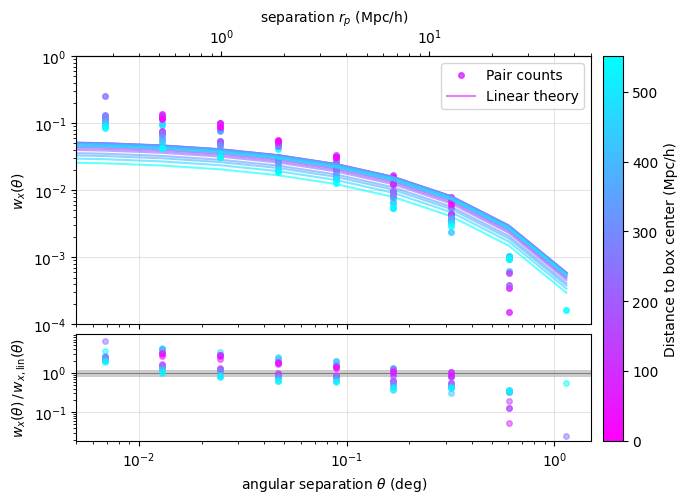

In [25]:
plot_wthetax(0.2, 0.7, 1.36, figsize=(8,5), ylim=(1e-4,1e0), title=False, legend_loc=0)

Text(0.45, 1.0, 'Phot. x spec. cross-correlations')

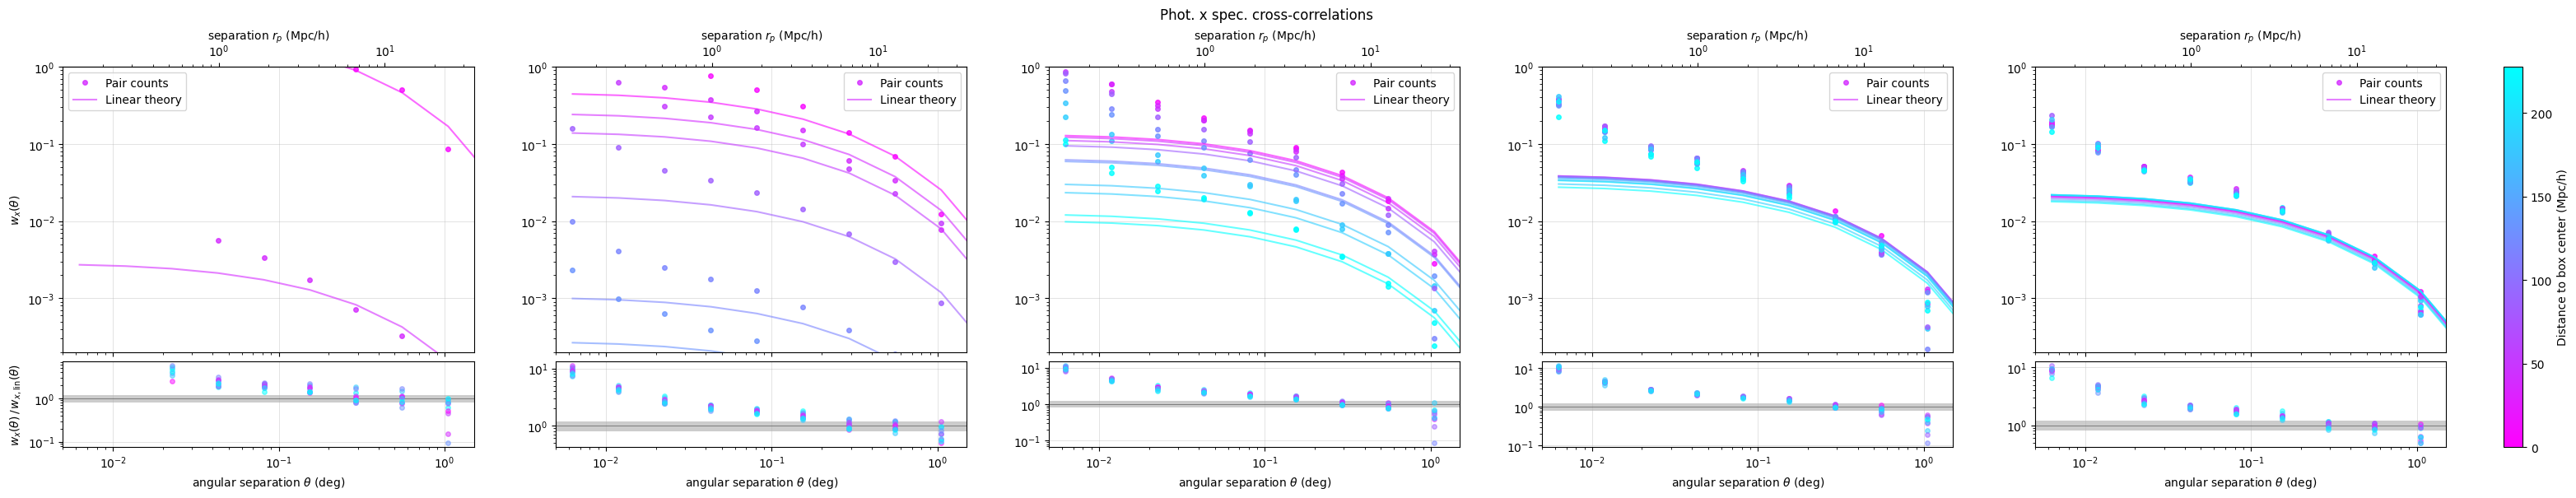

In [26]:
# PLOT ALL 

# load first result to get the common values
res = np.load(f'wthetax_res_sigmaz{sigma_zs[0]}.npy', allow_pickle=True).item()
chis, chis_fine = res['chis'], res['chis_fine']
rp_avg, thetaavg = res['rp_avg'], res['thetaavg']

fig = plt.figure(figsize=(9 * len(sigma_zs),6))
gs = mpl.gridspec.GridSpec(2, len(sigma_zs), height_ratios=[1,0.3], hspace=0.05)
# color by distance to box center
norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(np.abs(chis.value-np.nanmean(chis_fine))))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')

axs = []
for iz, sigma_z_ in enumerate(sigma_zs):
    # load dict
    res = np.load(f'wthetax_res_sigmaz{sigma_z_}.npy', allow_pickle=True).item()
    # unpack
    wthetax, wthetax_lin = res['wthetax'], res['wthetax_lin']
    # assert that these values are identical
    assert np.all(res['chis'] == chis)
    assert np.all(res['chis_fine'] == chis_fine)
    assert np.all(res['rp_avg'] == rp_avg)
    assert np.all(res['thetaavg'] == thetaavg)
    
    ax0 = fig.add_subplot(gs[0,iz])
    for i, w in enumerate(wthetax):
        kwargs = dict(c=smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine))))
        label = 'Pair counts' if i==len(wthetax)//2 else ''
        ax0.plot(thetaavg, w, marker='o', ms=4, ls='None', alpha=0.8, label=label, **kwargs)
        label = 'Linear theory' if i==len(wthetax)//2 else ''
        ax0.plot(thetaavg, wthetax_lin[i], alpha=0.6, label=label, **kwargs)
    secax = ax0.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
    secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
    ax0.set_ylim(2e-4,1e0)
    if iz == 0:
        ax0.set_ylabel(r'$w_x(\theta)$')
    ax0.legend()

    ax1 = fig.add_subplot(gs[1,iz])
    ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
    for i, w in enumerate(wthetax):
        ax1.plot(thetaavg, w / wthetax_lin[i], marker='o', ms=4, alpha=0.5, ls='None',
                 c=smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine))))
    ax1.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
    ax1.set_xlabel(r'angular separation $\theta$ (deg)')
    if iz == 0:
        ax1.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')

    for ax in (ax0, ax1):
        ax.loglog()
        ax.grid(alpha=0.5, lw=0.5)
        ax.set_xlim(5e-3, 1.5e0)
    axs.append(ax0)
    axs.append(ax1)
fig.colorbar(smap, ax=axs, label='Distance to box center (Mpc/h)', pad=0.02)
fig.suptitle('Phot. x spec. cross-correlations', x=0.45, y=1.)